# Neural Network - MakeMore pt.2 (14/04/2023)

Recap of lecture MakeMore pt.1 (12/04/2023):

In [1]:
import random
import torch

# Read Data

words = open('data/nomi_italiani.txt', 'r').read().splitlines()


random.seed(158)  # for reproducibility....often used !!
random.shuffle(words)

# Build vocabulary and simple encoder/decoder

chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

# Counting bigram

N = torch.zeros((28, 28), dtype=torch.int32)

for w in words:
    chs = ['.']+list(w)+['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

# Normalize Row to have Markovian Matrix P (each row is a prob. distribution)

P = N.float()
P = P/P.sum(1, keepdim=True)  # broadcasting at work !!! ...more in class...

<Axes: >

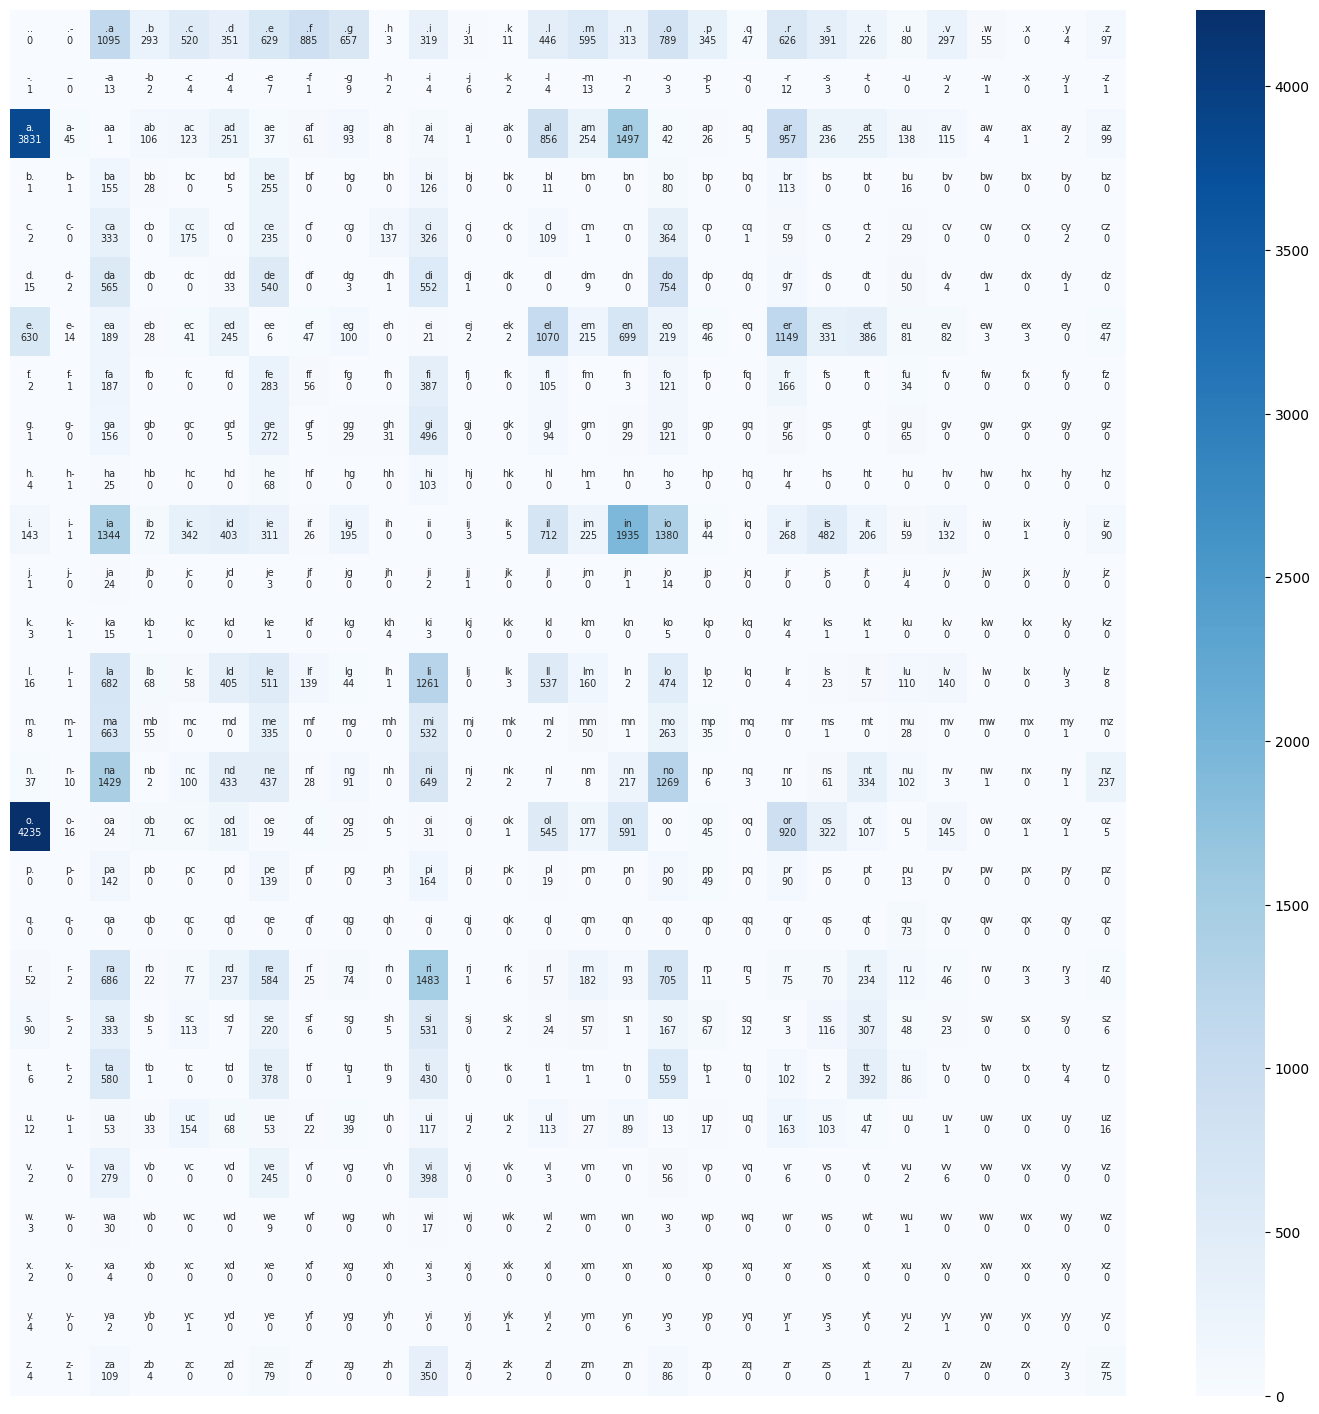

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
fig, ax = plt.subplots(figsize=(18, 18))
labels = np.array([[itos[i] + itos[j] + '\n' + str(N[i, j].item())
                  for j in range(28)] for i in range(28)])
sns.heatmap(N, xticklabels=False, yticklabels=False, fmt='', cmap='Blues',
            annot=labels, annot_kws={"fontsize": 6.9})  # nice font size

Row normalization will give us the conditional probability.
We need to go into real numbers to work with probability.
*keepdim=True* is necessary, otherwise we'll lose one dimension due to summing.

In [3]:
P = N.float()
print(P.shape)
P = P/P.sum(1, keepdim=True)  # broadcasting at work !!!

torch.Size([28, 28])


What does it mean broadcasting?
Sometimes we do operations, e.g. addition, multiplication.
Assuming $\vec{v} = (1,2,3,4)$, what's $\vec{v} +1$?
Broadcasting means that PyTorch generalizes the sum in the most natural way, giving as result $(2,3,4,5)$.
We can see broadcasting as extending over another dimension (or also more than one), as before the scalar became a vector.

**NOTE**: square brackets in Python indicate a vector.

In [4]:
P = N.float()
X = P.sum(1, keepdim=True)
Y = P.sum(1)
print(P.shape, X.shape, Y.shape)

torch.Size([28, 28]) torch.Size([28, 1]) torch.Size([28])


In [5]:
X1 = P/X
Y1 = P/Y
print(X1.shape, Y1.shape)
print(X1[3].sum(), Y1[3].sum())

torch.Size([28, 28]) torch.Size([28, 28])
tensor(1.) tensor(0.1743)


The first is normalized, the second not...
They have the same size, but one is normalized on columns instead of rows.
Basically, dividing by $X$ we divide every value with a single value, dividing by $\vec{Y}$ we do a dot division (each element with the corresponding one).
In Torch the function view() permit us to see data in different ways.
There are formal math rules for broadcasting, we'll let Torch do the hard work.

In [6]:
A = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7])
print(A.view(8))
print(A.view(4, 2))
print(A.view(2, 4))
print(A.view(2, 2, 2))

tensor([0, 1, 2, 3, 4, 5, 6, 7])
tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7]])
tensor([[0, 1, 2, 3],
        [4, 5, 6, 7]])
tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])


Now we can sample ang generate sequences.
We ask torch to use a multinomial distribution with $\vec{p}$ of 28 dimensions.

In [7]:
P = N.float()
P = P / P.sum(1, keepdim=True)
g = torch.Generator().manual_seed(12340)

for i in range(10):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

vevia.
lete.
isto.
siobela.
estio.
jo.
to.
do.
go.
y.


We did not use networks and complex things, just definitions.
Now we want to evaluate how good (or bad) is our model.
Our model is actually the probability $p$ ($\mu$ in class).
Given this model we know the probability to see a word.
We want to compute $-\log\mu$, remarking that $\log(abc) = \log a + \log b + \log c$.

Look at the probability of each bigram, take the log and save the result in the likelihood variable (minus the log of ...).
Finally, we compute the mean.

In [8]:
# log-likelhood !!  log(a*b*c)=log a + log b + log c
log_likelihood = 0.0
n = 0
for w in words[:3]:
    chs = ['.']+list(w)+['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}:{prob:.4f}:{logprob:.4f}')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

.a:0.1203:-2.1181
ar:0.1050:-2.2542
rg:0.0151:-4.1899
ge:0.2000:-1.6094
en:0.1236:-2.0908
nt:0.0610:-2.7975
to:0.2188:-1.5197
o.:0.5585:-0.5825
.g:0.0722:-2.6289
gi:0.3647:-1.0087
io:0.1647:-1.8036
ov:0.0191:-3.9569
va:0.2798:-1.2735
an:0.1642:-1.8068
nn:0.0396:-3.2288
ni:0.1185:-2.1332
in:0.2309:-1.4656
no:0.2316:-1.4627
o.:0.5585:-0.5825
.l:0.0490:-3.0163
li:0.2672:-1.3197
ic:0.0408:-3.1987
cu:0.0163:-4.1143
ur:0.1424:-1.9494
rg:0.0151:-4.1899
ga:0.1147:-2.1654
a.:0.4202:-0.8671
log_likelihood=tensor(-59.3341)
nll=tensor(59.3341)
2.197558879852295


But we want to do better (not too much - overfitting).

In [9]:
log_likelihood = 0.0
n = 0
for w in ['mirkoo']:
    chs = ['.']+list(w)+['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}:{prob:.4f}')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

.m:0.0653
mi:0.2694
ir:0.0320
rk:0.0012
ko:0.1282
oo:0.0000
o.:0.5585
log_likelihood=tensor(-inf)
nll=tensor(inf)
inf


To prevent infinity we use *smoothing*, similarly to Google's PageRank.

In [10]:
K = 1
P = (N+K).float()
P = P/P.sum(1, keepdim=True)

In [11]:
log_likelihood = 0.0
n = 0
for w in ['mirkoo']:
    chs = ['.']+list(w)+['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}:{prob:.4f}')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

.m:0.0653
mi:0.2661
ir:0.0320
rk:0.0014
ko:0.0896
oo:0.0001
o.:0.5566
log_likelihood=tensor(-25.9854)
nll=tensor(25.9854)
3.71219801902771


To scale up this model we need to so something better.
This works well for bigrams, not n-grams...
We cannot just reproduce probability by counting but a dynamical way for representing the information.
To change perspective, we always need the probability of the next character, improving our matrix by *learning*.
Let's try with gradient.

Taking *argento*, the first word, which has 8 bigrams.
Consider every bigram as input/output, labelling them.
Tensor are encoded characters.

In [12]:
xs, ys = [], []

for w in words[:1]:
    chs = ['.']+list(w)+['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs)
print(ys)

. a
a r
r g
g e
e n
n t
t o
o .
tensor([ 0,  2, 19,  8,  6, 15, 21, 16])
tensor([ 2, 19,  8,  6, 15, 21, 16,  0])


Now we want to construct something which takes out a character giving us a probability distribution over the alphabet (just the row).
BUT WE DON'T WANT TO COUNT.

The most "natural" thing one can think is, given 1,2,3 (three number), how can we represent them in a smart way?
By considering them as vertex of a *simplex* (1,0,0), (0,1,0), (0,0,1).

See the *one_hot encoding*: every integer is a string of zero with a one in the position.
The max integer gives the dimension.
This encoding is a functional in tensor.

In [13]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=28).float()
print(xenc)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
  

<Axes: >

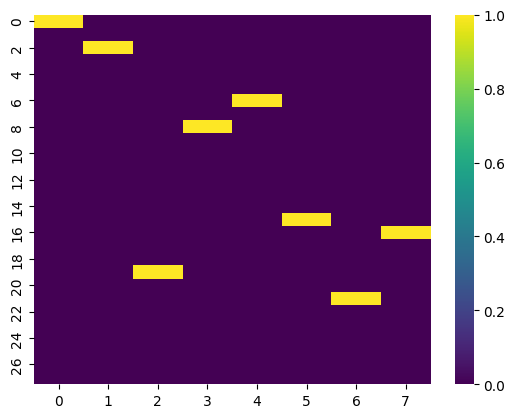

In [14]:
sns.heatmap(xenc.T, fmt='', cmap='viridis')

We can see this as a probability distribution, in particular as a *delta function*.
Our word ('argento') is represented by a vector ($xenc$ above).

Now we want to implement our first "neuron".
We consider a matrix $W$ of weights which will transform our input data $\vec{x}$ by the simplest transformation we can think of, a scalar product, to produce our output,
$$
    \vec{x} \longrightarrow \hat{W} \cdot \vec{x} = \vec{y}
$$
we interpret $W$ as our **neuron**, and eventually we usually add to the result a bias $b$ to generalize the linearity of the transformation.

Every vector $\vec{v} = (0, \ldots, 1, \ldots, 0) \in \mathbb{R}^{28}$, so we can do
$$
    \vec{x} \longrightarrow \hat{W} \cdot \vec{x} + \vec{b} = \vec{y}
$$
with $W$ 28x28 *weight* matrix.
This is simply a neural network, with a bias $\vec{b}$.
We want 28 neurons in output, one for each letter.
**NOTE**: our goal is to obtain the distribution, i.e. a 28 dim vector.

In [15]:
W = torch.randn((28, 28))  # n means normally distributed

print((xenc @ W).shape)
# weights in the coloumn and pointwise multiplication... pytorch take care of it...
print((xenc @ W)[3, 13])  # 13th-neuron in 3 example...
print((xenc[3]*W[:, 13]).sum())

torch.Size([8, 28])
tensor(0.4590)
tensor(0.4590)


How to interpret $W$?
Values are both negative or positive, but they are *not* counting, **they are the logarithm of counting!**
Taking the logit exponential, we've the equivalent of $N$ (the count), which we can normalize as we did previously.

In [16]:
logits = xenc @ W  # log-counts
print(logits.shape)
counts = logits.exp()  # equivalent N
print(counts.shape)
probs = counts/counts.sum(1, keepdims=True)
print(probs.shape)

torch.Size([8, 28])
torch.Size([8, 28])
torch.Size([8, 28])


In [17]:
# randomly initialize 28 neurons' weights, each neuron recevies 28 inputs
g = torch.Generator().manual_seed(123450)
W = torch.randn((28, 28), generator=g)

Now we have 8 input (*argento*) and the random matrix $W$.
*probs* is a sequence of probability vectors.

In [18]:
# input to network: one-hot encoding
xenc = F.one_hot(xs, num_classes=28).float()
logits = xenc @ W  # predict log-counts
counts = logits.exp()  # counts, equivalent to N !!
probs = counts/counts.sum(1, keepdims=True)  # probabilites for next character
# NOTE: the last two lines here are together called 'SoftMax'

Random weights give bad predictions, obviously.

In [19]:
# just to break down the example....
nlls = torch.zeros(6)
for i in range(6):
    # i-th bigram:
    x = xs[i].item()  # input character index
    y = ys[i].item()  # label character index
    print('----------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilites from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('============')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

----------
bigram example 1: .a (indexes 0,2)
input to the neural net: 0
output probabilites from the neural net: tensor([0.0454, 0.0338, 0.0125, 0.1300, 0.0234, 0.0069, 0.0735, 0.0705, 0.0096,
        0.0103, 0.0322, 0.0363, 0.1015, 0.0112, 0.0229, 0.0132, 0.0414, 0.0708,
        0.0105, 0.0292, 0.0567, 0.0172, 0.0581, 0.0194, 0.0303, 0.0088, 0.0168,
        0.0079])
label (actual next character): 2
probability assigned by the net to the correct character: 0.012508641928434372
log likelihood: -4.381335735321045
negative log likelihood: 4.381335735321045
----------
bigram example 2: ar (indexes 2,19)
input to the neural net: 2
output probabilites from the neural net: tensor([0.0402, 0.0033, 0.1244, 0.0228, 0.0029, 0.0638, 0.0727, 0.0334, 0.0098,
        0.0233, 0.0240, 0.0180, 0.0477, 0.0364, 0.0330, 0.1078, 0.0215, 0.0903,
        0.0041, 0.0254, 0.0523, 0.0465, 0.0045, 0.0177, 0.0161, 0.0252, 0.0037,
        0.0290])
label (actual next character): 19
probability assigned by the net t

In [20]:
# nlls is made by differential functions and we try to optimize using gradient discendent..

print(probs[torch.arange(8), ys])
loss = -probs[torch.arange(8), ys].log().mean()
print(loss)

tensor([0.0125, 0.0254, 0.0054, 0.0183, 0.0471, 0.0107, 0.0469, 0.1470])
tensor(3.7318)


Now let's try to *learn*, i.e. to optimize our model.
What is the **loss**?
It's a function which depends on the input and on the weights.
The loss is the average negative log likelihood: a.k.a., the **entropy**, the loss of information.
We would like to minimize such loss for our system to make good predictions. How do we do it?
We use **gradient descent**.

Let's consider $8$ examples now.
We first do the **forward pass**: we feed this input to our system $W$ and calculate the probability distribution and the loss.

In [21]:
# forward pass
# input to network: one-hot encoding
xenc = F.one_hot(xs, num_classes=28).float()
logits = xenc @ W  # predict log-counts
counts = logits.exp()  # counts, equivalent to N !!
# probabilities of the next character
probs = counts/counts.sum(1, keepdims=True)
loss = -probs[torch.arange(8), ys].log().mean()

The loss function $H$ depends on functions $\vec{f}$ (one hot encoding, log and exp of our data) of all the parameters, let's call them $\vec{\theta}$.
Since we would like to optimize our system by minimizing the loss $H(\vec{f}(\vec{\theta}))$ using gradient descent, we need to compute all the derivatives $\frac{\partial H}{\partial f_i} \frac{\partial f_i}{\partial \theta_j}$: a very huge number of calculations.
Luckily, there is actually a very efficient way of doing it using PyTorch.
It is done by the $backward$ function in it.   

Let's compute the derivative of the function with respect to all the parameters.
Then, update all $W$ values (parameters) by the learning rate.

In [22]:
# backward pass
W.grad = None
loss.requires_grad = True
loss.backward()  # lot of computations hidden here

In [23]:
# create the data set

xs, ys = [], []

for w in words:
    chs = ['.']+list(w)+['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()  # add this...comment
print('number of samples: ', num)

# initialize the (one layer) 'network'
g = torch.Generator().manual_seed(123450)
W = torch.randn((28, 28), generator=g, requires_grad=True)

number of samples:  73643


In [24]:
# gradient descent

for k in range(100):
    # forward pass
    # input to network: one-hot encoding
    xenc = F.one_hot(xs, num_classes=28).float()
    logits = xenc @ W  # predict log-counts
    counts = logits.exp()  # counts, equivalent to N !!
    # probabilities of the next character
    probs = counts/counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()
    if k % 5 == 0:
        print('loss', loss.item())
    # backward pass
    W.grad = None  # comment in class ! set to zero the gradient !
    loss.backward()  # lot of computations hidden here
    # update parameter
    # try different 'learning rate': .1, ... 50
    W.data += -10 * W.grad

loss 3.464167833328247
loss 3.054328203201294
loss 2.8560686111450195
loss 2.730919122695923
loss 2.643649101257324
loss 2.579237937927246
loss 2.5293197631835938
loss 2.4893062114715576
loss 2.456550121307373
loss 2.4293432235717773
loss 2.4064884185791016
loss 2.3871099948883057
loss 2.3705432415008545
loss 2.356271505355835
loss 2.3438825607299805
loss 2.3330447673797607
loss 2.323490619659424
loss 2.3150062561035156
loss 2.3074193000793457
loss 2.3005921840667725


Repeating such back propagation we get the minimization of loss and the training of our Neural Network.
Spoiler: results are not very good now, but we can improve them by complexifying our Neural Network architecture and by optimizing our training samples.